In [1]:
import sys
sys.path.insert(0, "..")

from base_f import daily_climatology, spatial_avg_daily_input, spatial_stats_daily_input, compute_anomalies, create_it_matrix
from cross_validation_f import SVR_nested_CV_gridsearch, SVR_PCA_nested_CV_gridsearch
from cross_validation_f import evaluate_prediction, plot_prediction, plot_anomalies
from cross_validation_f import nested_CV_PCA_SVR_predict, nested_CV_SVR_predict
from cross_validation_f import classic_CV_PCA_SVR_predict, classic_CV_SVR_predict


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import os
import pdb
import seaborn as sns

nb_name = ''

In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\\'
daily_input = pd.read_csv(path+nb_name[:-6]+'.csv', index_col=0, parse_dates=True)

In [4]:
daily_input

,T,T5,T25,T75,T95,E,E5,E25,E75,E95,...,P5,P25,P75,P95,S,S5,S25,S75,S95,Q
1993-07-26,283.265917,277.804296,280.516412,285.641009,289.938080,2.413384,1.625507,2.002202,2.797662,3.309632,...,-0.000261,5.740592,17.619283,24.256218,7.042373,0.0,0.0,0.00,0.00,NaN
1993-07-27,284.256883,278.862241,281.740732,286.481343,290.438699,3.263684,2.280932,2.850147,3.667771,4.054549,...,-0.007789,-0.003518,-0.000486,0.081819,6.697740,0.0,0.0,0.00,0.00,NaN
1993-07-28,287.467294,281.826776,284.358081,290.250831,294.594946,3.146403,1.803030,2.566930,3.801986,4.456705,...,-0.004873,-0.001106,2.529912,11.023671,6.262712,0.0,0.0,0.00,0.00,NaN
1993-07-29,290.105726,284.860777,287.285703,292.591199,296.598104,4.254335,3.654429,4.037142,4.502540,4.803387,...,-0.007532,-0.003139,-0.000438,0.020516,5.615819,0.0,0.0,0.00,0.00,NaN
1993-07-30,290.762134,285.632761,287.978541,293.098539,297.252671,4.479970,3.714184,4.203136,4.809166,5.167927,...,-0.007360,-0.002846,-0.000580,-0.000120,4.994350,0.0,0.0,0.00,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,266.350790,260.528940,263.776517,269.547386,272.218992,0.270449,-0.163241,0.091719,0.435928,0.709284,...,0.001541,0.003884,0.022503,0.108691,109.166667,0.0,33.0,165.75,254.05,61.7740
2020-12-27,264.863088,259.639339,262.328126,267.709815,270.419789,0.099872,-0.269642,-0.093051,0.278507,0.541581,...,0.000286,0.000862,0.008081,0.030325,109.124294,0.0,33.0,165.75,254.05,50.5436
2020-12-28,267.947858,263.449217,266.059233,270.248491,272.518124,0.164116,-0.062735,0.077256,0.266129,0.366879,...,8.501494,13.599958,19.326652,24.565633,125.559322,14.0,47.0,184.00,273.70,76.6964
2020-12-29,268.243409,262.650050,266.469633,270.545853,273.025460,0.054990,-0.166500,-0.057225,0.167581,0.266021,...,0.021073,0.141813,0.559502,1.714429,126.045198,14.0,48.0,185.75,275.75,83.7263


In [6]:
t_unit=10

#define the possible parameters value (where Gridsearch is applied)


C_range=np.logspace(-1.2, -0.4, 5)
epsilon_range=np.logspace(-6, -4, 4)
#n_range = [17, 50, 200]
components_range = [5*4*36]
#do not enlarge t_range for now
t_range=[36]
t_length=t_range[0]
n_splits=4
test_size=730

Fitting 1 folds for each of 20 candidates, totalling 20 fits
Fitting 1 folds for each of 20 candidates, totalling 20 fits
Fitting 1 folds for each of 20 candidates, totalling 20 fits
Fitting 1 folds for each of 20 candidates, totalling 20 fits

C=0.15848931924611134
eps=1e-06


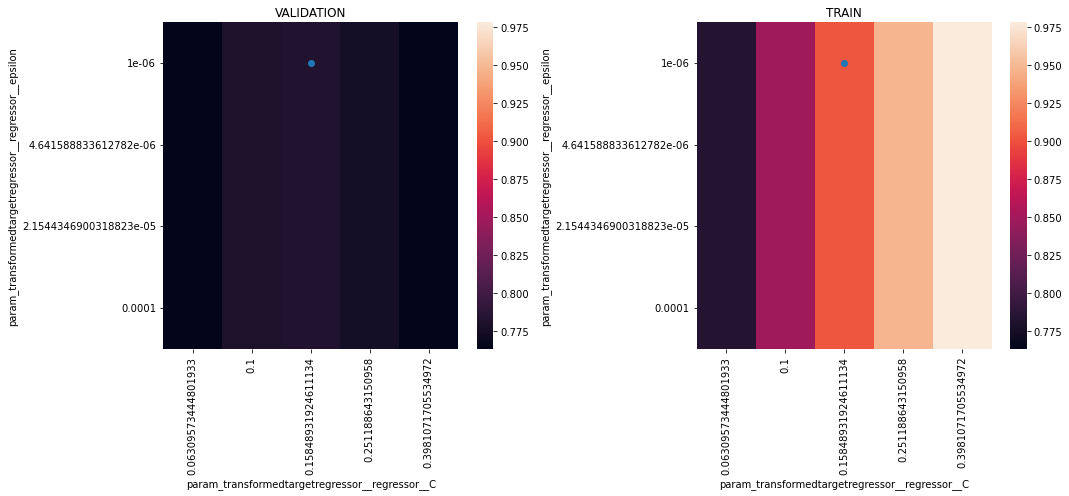

In [7]:
C, eps = SVR_nested_CV_gridsearch(daily_input, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C={C}')
print(f'eps={eps}')
#run 03/02

In [8]:
radius_for_ensemble = 1
predictions = nested_CV_SVR_predict(daily_input, C, eps, t_length,t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

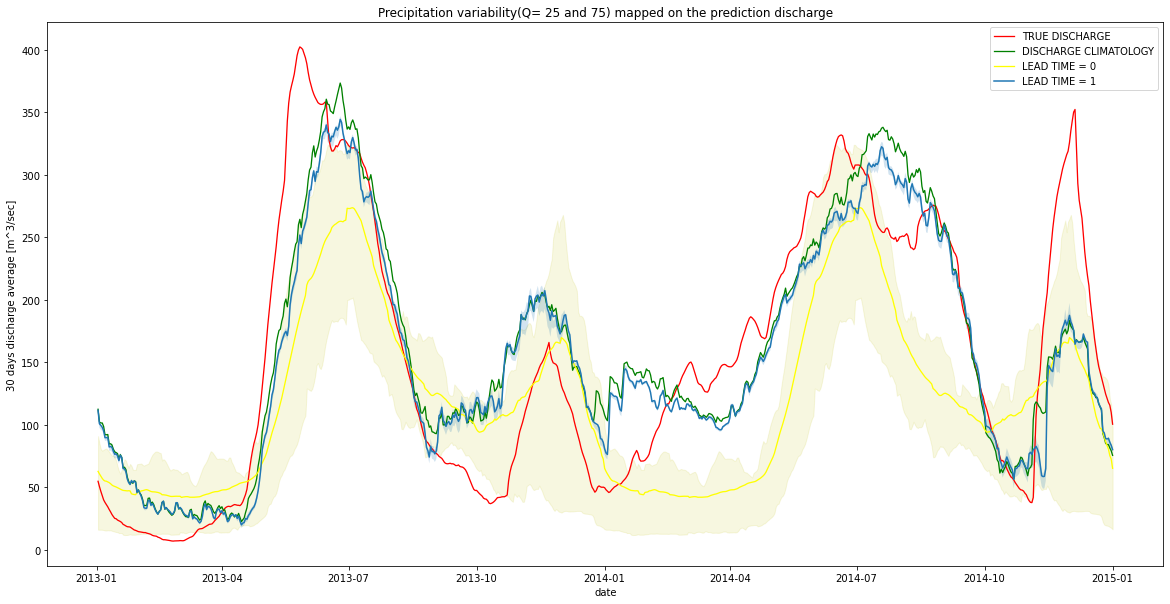

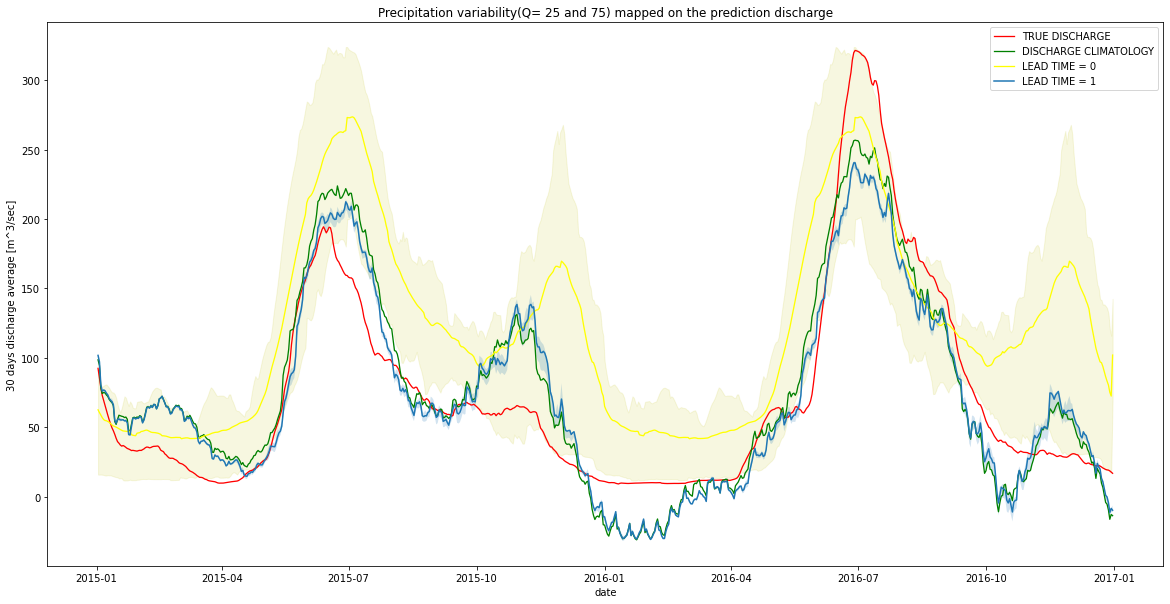

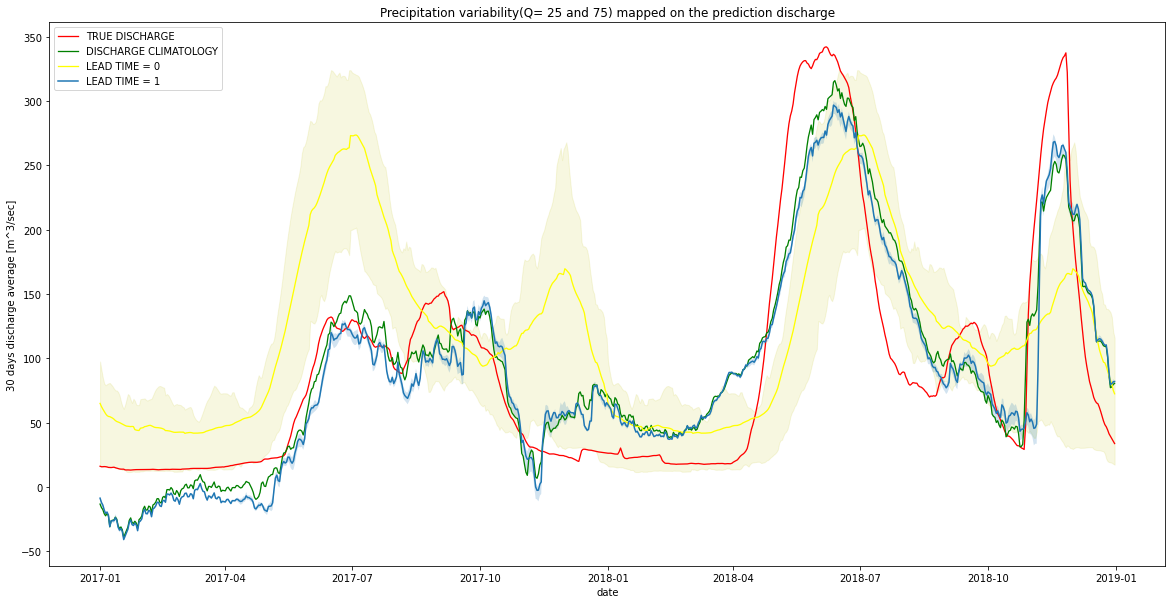

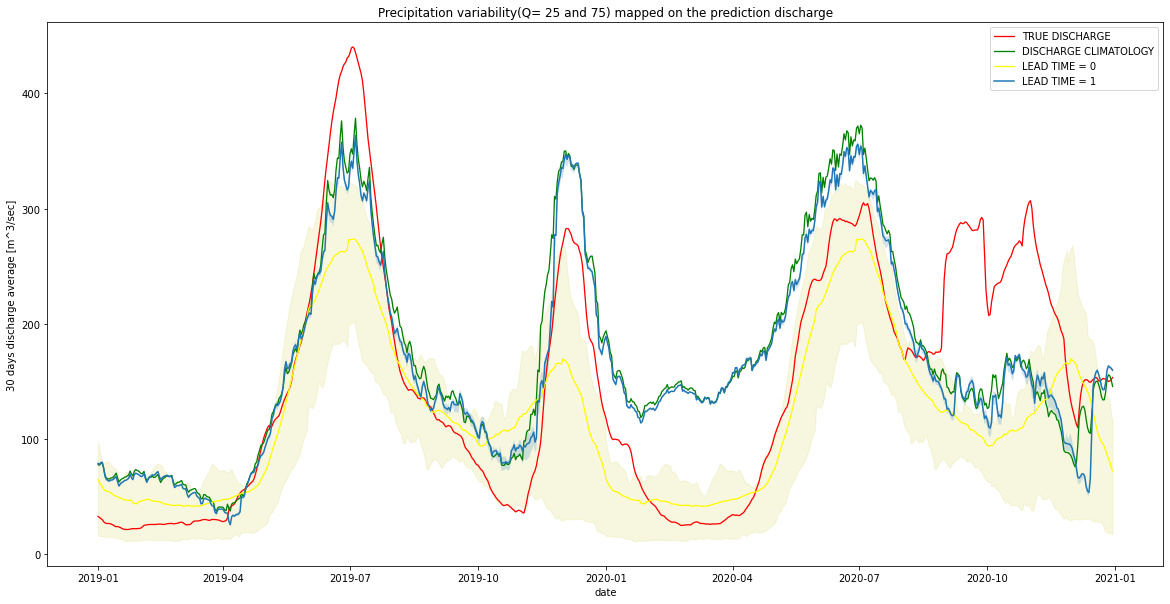

In [9]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions)


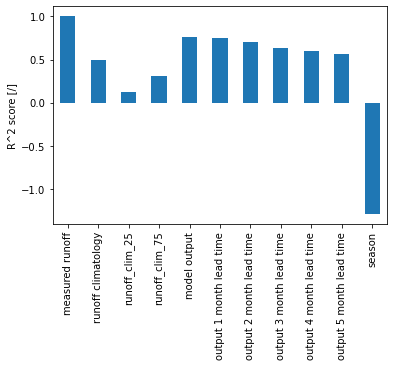

In [10]:
from cross_validation_f import evaluate_class, evaluate_class_season
clas=evaluate_class_season(predictions)
clas.index=np.repeat(nb_name[:-6],4)
clas.to_csv('class_res.csv', mode='a', header=False)

r=pd.DataFrame(evaluate_prediction(predictions)).transpose()
r['STAT_CODE']=(nb_name[:-6])
r.index=r.STAT_CODE
r.drop(columns=['season','runoff_clim_25','runoff_clim_75','STAT_CODE'],inplace=True)
r.to_csv('r_res.csv',mode='a',header=False)

measured runoff             1.000000
runoff climatology          0.494862
runoff_clim_25              0.129099
runoff_clim_75              0.312857
model output                0.755302
output 1 month lead time    0.748785
output 2 month lead time    0.703410
output 3 month lead time    0.635202
output 4 month lead time    0.596153
output 5 month lead time    0.567952
season                     -1.290153
dtype: float64

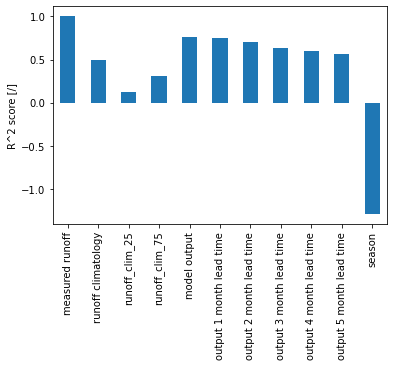

In [11]:
evaluate_prediction(predictions)

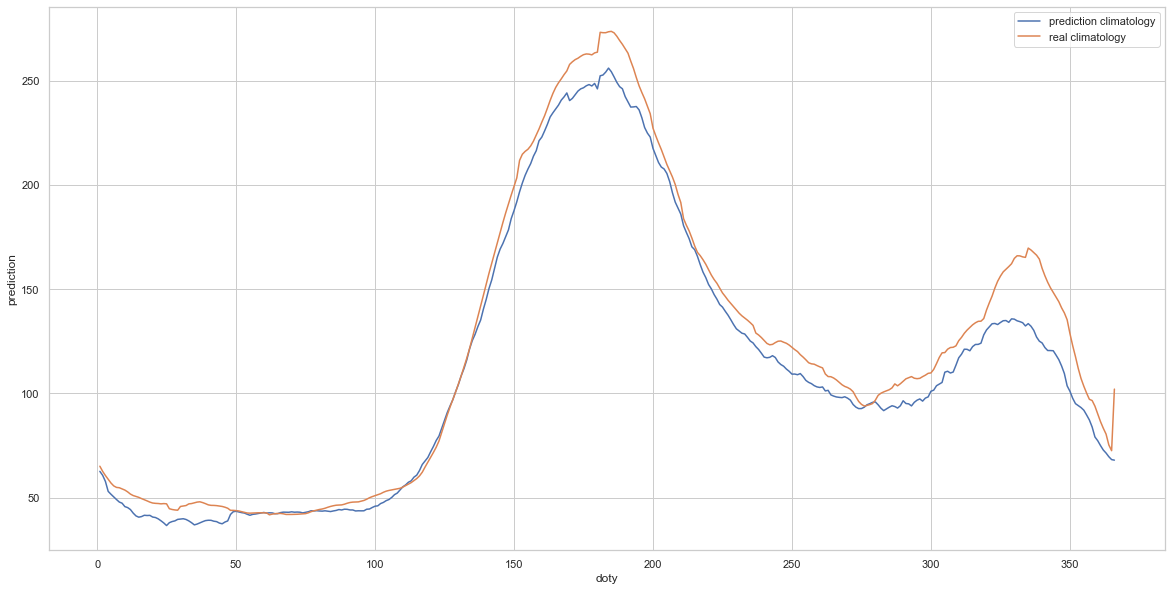

In [12]:
predictions_for_clim = classic_CV_SVR_predict(daily_input, C, eps, t_length,t_unit, n_splits)
climatologies =predictions_for_clim.groupby(by=predictions_for_clim.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies['doty']=climatologies.index

sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()


from db_insert import insert
insert(nb_name[:-6],predictions_for_clim)

In [13]:
##develop model savior

from sklearn.svm import SVR, LinearSVR
from base_f import create_it_matrix
from joblib import dump, load

it_matrix=create_it_matrix(daily_input,t_length,t_unit).astype('float32')

X = it_matrix.drop(columns='Q')
y = it_matrix['Q']
svr_estimator = SVR(kernel='rbf', gamma='scale', cache_size=15000,C=C,epsilon=eps)

svr_estimator = make_pipeline(StandardScaler(),
                              TransformedTargetRegressor(regressor=svr_estimator, transformer=StandardScaler()))

svr_estimator.fit(X, y)

path='models/'+nb_name[:-6]+'.joblib'

dump(svr_estimator, path)

['models/ADO_DSC_ITH2_0035.joblib']